In [1]:
import pandas as pd
import funciones

import pygad
import time
import numpy as np


In [2]:
datos= pd.read_csv("dataset2_covid_train_balanceado_final.csv")

In [3]:
datos = datos.rename(columns={'corona_result':'class'})

datos

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,class
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
126869,0,1,0,0,0,1,0,0,1
126870,1,1,1,1,0,1,0,0,1
126871,1,0,0,0,0,0,1,0,1
126872,0,0,0,0,0,1,0,0,1


In [4]:

feature_columns = [col for col in datos.columns if col != 'class']

print("---  Tasa de Inconsistencia por Atributo Individual ---")

# Diccionario para guardar los resultad
tasas_individuales = {}

for feature in feature_columns:
    
  
    
    rate = funciones.tasa_inconsistencia(
        df=datos, 
        subconjunto_caracteristicas=[feature], 
        clase='class'
    )
    
    tasas_individuales[feature] = rate
    print(f"Feature: {feature:<30} | Tasa Inc: {rate:.5f}")

print("---------------------------------------------------------")

---  Tasa de Inconsistencia por Atributo Individual ---
Feature: cough                          | Tasa Inc: 0.31653
Feature: fever                          | Tasa Inc: 0.29889
Feature: sore_throat                    | Tasa Inc: 0.42777
Feature: shortness_of_breath            | Tasa Inc: 0.44925
Feature: head_ache                      | Tasa Inc: 0.39408
Feature: age_60_and_above               | Tasa Inc: 0.47596
Feature: gender                         | Tasa Inc: 0.46682
Feature: test_indication                | Tasa Inc: 0.26676
---------------------------------------------------------


In [5]:


dataframe = datos
feature_names= [col for col in datos.columns if col != 'class']
target = 'class'
def fitness_para_pygad(ga_instance, solution, solution_idx):

    fitness=funciones.fitness_mod_nsga2(solution,dataframe, feature_names, target )
    return fitness

In [6]:

def callback_generation(ga_instance):
    current_time = time.time()
    duration = current_time - ga_instance.last_execution_time
    
    print(f"Generación                : {ga_instance.generations_completed}")
    
    if hasattr(ga_instance, 'pareto_fronts') and ga_instance.pareto_fronts and len(ga_instance.pareto_fronts) > 0:
        
        # 1. Obtener los índices de las soluciones en el mejor frente
        indices_del_mejor_frente = ga_instance.pareto_fronts[0][:, 0].astype(int)
        
        # 2. Obtener las soluciones y sus fitness ya calculados
        soluciones_del_frente = ga_instance.population[indices_del_mejor_frente]
        fitness_del_frente = ga_instance.last_generation_fitness[indices_del_mejor_frente]
        
        # 3. Calcular el rango del número de características
        num_features_en_frente = [np.sum(sol) for sol in soluciones_del_frente]
        
        print(f"Soluciones en Frente Pareto : {len(soluciones_del_frente)}")
        
        if num_features_en_frente:
            print(f"  - Rango de Características: de {min(num_features_en_frente):.0f} a {max(num_features_en_frente):.0f}")
        
        # --- NUEVA LÓGICA: CALCULAR Y MOSTRAR RANGO DE FITNESS ---
        if fitness_del_frente.size > 0:
            # Separamos los valores de fitness para cada objetivo
            # fitness_del_frente[:, 0] contiene todos los valores del primer objetivo
            # fitness_del_frente[:, 1] contiene todos los valores del segundo objetivo
            
            # Rango para el Objetivo 1 (Consistencia)
            min_fitness_obj1 = np.min(fitness_del_frente[:, 0])
            max_fitness_obj1 = np.max(fitness_del_frente[:, 0])
            
            # Rango para el Objetivo 2 (Simplicidad)
            min_fitness_obj2 = np.min(fitness_del_frente[:, 1])
            max_fitness_obj2 = np.max(fitness_del_frente[:, 1])

            print(f"  - Rango Fitness (Obj. 1)  : de {min_fitness_obj1:.8f} a {max_fitness_obj1:.8f}")
            print(f"  - Rango Fitness (Obj. 2)  : de {min_fitness_obj2:.0f} a {max_fitness_obj2:.0f}")
        # --- FIN DE LA NUEVA LÓGICA ---

    print(f"Duración de la Generación : {duration:.2f} segundos")
    print("------------------------------------------")
    
    ga_instance.last_execution_time = current_time

In [7]:
#Algoritmo genetico para la seleccion de variables.
num_genes = len(dataframe.columns)-1
sol_per_pop= 100
num_generations=20
ga_instance = pygad.GA(
    num_generations=20,
    num_parents_mating=100, #numero de padres que seran seleccionados para reproducirse.
    parent_selection_type="tournament_nsga2",
    K_tournament= 2,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=[0, 1],
    mutation_type="random",
    mutation_probability = 0.000358, #1% para cada cromosoma, 
    fitness_func=fitness_para_pygad,
    save_solutions=True,
    on_generation=callback_generation
)

/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/pygad/pygad.py:1158: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


In [8]:
import time
ga_instance.last_execution_time = time.time()

ga_instance.run()

Generación                : 1
Soluciones en Frente Pareto : 5
  - Rango de Características: de 2 a 6
  - Rango Fitness (Obj. 1)  : de 0.69892965 a 0.86653688
  - Rango Fitness (Obj. 2)  : de 2 a 6
Duración de la Generación : 5.72 segundos
------------------------------------------
Generación                : 2
Soluciones en Frente Pareto : 10
  - Rango de Características: de 1 a 5
  - Rango Fitness (Obj. 1)  : de 0.70110503 a 0.86078314
  - Rango Fitness (Obj. 2)  : de 3 a 7
Duración de la Generación : 1.05 segundos
------------------------------------------
Generación                : 3
Soluciones en Frente Pareto : 11
  - Rango de Características: de 1 a 5
  - Rango Fitness (Obj. 1)  : de 0.70110503 a 0.86623737
  - Rango Fitness (Obj. 2)  : de 3 a 7
Duración de la Generación : 0.68 segundos
------------------------------------------
Generación                : 4
Soluciones en Frente Pareto : 13
  - Rango de Características: de 2 a 4
  - Rango Fitness (Obj. 1)  : de 0.73323928 a 0.86

In [9]:
ga_instance.save(filename="NSGA2-covid2")

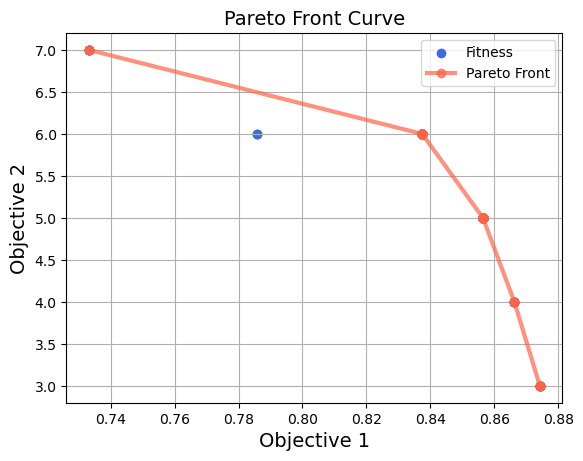

In [10]:
busqueda1 = pygad.load("/home/juan/proyectoTesis/algoritmos_geneticos/NSGA2-covid2")

busqueda1.plot_pareto_front_curve();

In [11]:
pareto_solutions, pareto_fitness, pareto_idx = busqueda1.best_solution()

print(pareto_solutions)

[0. 0. 0. 0. 0. 0. 0. 1.]


In [12]:

pareto_solutions = np.array(pareto_solutions)
pareto_fitness = np.array(pareto_fitness)

if pareto_solutions.ndim == 1:
    pareto_solutions = pareto_solutions.reshape(1, -1)
    pareto_fitness = pareto_fitness.reshape(1, -1)

for i, solution in enumerate(pareto_solutions):
    
    # DECODIFICACIÓN: Si el gen es 1, tomamos el nombre de la columna correspondiente
    selected_cols = [feature_names[j] for j in range(len(solution)) if solution[j] == 1]
    #print(solution)
    # Extraer los fitness individuales
    fit_consistencia = pareto_fitness[i][0]
    fit_reduccion = pareto_fitness[i][1]
    
    print(f"Solución 1")
    print(f"Fitness Consistencia: {fit_consistencia:.4f}")
    print(f"Fitness Reducción: {fit_reduccion:.1f} (Usó {len(selected_cols)} variables)")
    print(f"Variables Seleccionadas: {selected_cols}")

Solución 1
Fitness Consistencia: 0.7332
Fitness Reducción: 7.0 (Usó 1 variables)
Variables Seleccionadas: ['test_indication']


In [13]:
import numpy as np

# 1. Accedemos a la población final y sus fitness
poblacion_final = busqueda1.population
fitness_final = busqueda1.last_generation_fitness

print(f"Explorando la población final ({len(poblacion_final)} individuos)...")
print("-" * 60)

soluciones_encontradas = 0
fitness_vistos = [] # Para no repetir soluciones idénticas

for i in range(len(poblacion_final)):
    solucion = poblacion_final[i]
    # Los fitness vienen en una lista [obj1, obj2]
    fit_consistencia = fitness_final[i][0]
    fit_reduccion = fitness_final[i][1]
    
    # Evitar imprimir duplicados (el algoritmo genético tiende a converger en clones)
    if list(fitness_final[i]) in fitness_vistos:
        continue
    fitness_vistos.append(list(fitness_final[i]))
    # Buscamos que Fitness Reducción sea 3 (Quitar 3 variables)
    if fit_reduccion == 3:
        soluciones_encontradas += 1
        
        # Decodificar nombres
        cols_seleccionadas = [feature_names[j] for j in range(len(solucion)) if solucion[j] == 1]
        cols_eliminadas = [feature_names[j] for j in range(len(solucion)) if solucion[j] == 0]
        
        print(f"Consistencia: {fit_consistencia:.4f}")
        print(f"Reducción:    {fit_reduccion} (Eliminó {len(cols_eliminadas)} variables)")
        print(f" SELECCIÓN ({len(cols_seleccionadas)}): {cols_seleccionadas}")
        print(f"ELIMINADAS: {cols_eliminadas}")
        print("-" * 60)

if soluciones_encontradas == 0:
    print("No se encontró ninguna solución única que elimine exactamente 3 variables.")
    print("Intenta buscar con fit_reduccion == 2 o 4.")
    
    # Imprimir todas las opciones únicas disponibles para que veas qué hay
    print("\n--- Opciones disponibles (Reducción) ---")
    for fit in fitness_vistos:
        print(f"Reducción: {fit[1]} | Consistencia: {fit[0]:.4f}")

Explorando la población final (100 individuos)...
------------------------------------------------------------
Consistencia: 0.8742
Reducción:    3.0 (Eliminó 3 variables)
 SELECCIÓN (5): ['fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'test_indication']
ELIMINADAS: ['cough', 'age_60_and_above', 'gender']
------------------------------------------------------------


In [25]:
col = ['fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'test_indication', 'cough']

df_paper= dataframe[col].join(dataframe['class'])
tasa_de_variables_del_paper = funciones.tasa_inconsistencia(df_paper, col, "class")

print(1-tasa_de_variables_del_paper)

0.874205905071173
